In [2]:
import os
import random
import shutil
import json

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

import torchaudio
import torchaudio.transforms as transforms

import pytorch_lightning as pl

c:\Users\Asus\miniconda3\envs\majorproject\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [37]:
from focal_loss.focal_loss import FocalLoss

# Withoout class weights
criterion = FocalLoss(gamma=0.7)

# with weights 
# The weights parameter is similar to the alpha value mentioned in the paper
weights = torch.FloatTensor([2, 3.2, 0.7])
criterion = FocalLoss(gamma=0.7, weights=weights)

# to ignore index 
criterion = FocalLoss(gamma=0.7, ignore_index=0)

# To make it behaves as CrossEntropy loss
criterion = FocalLoss(gamma=0)

In [41]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        #         focal_loss = self.alpha[targets] * (1 - pt)**self.gamma * ce_loss
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        focal_loss = focal_loss.mean()

        return focal_loss
    


In [48]:
batch_size = 10
m = torch.nn.Sigmoid()
logits = torch.randn(batch_size)
target = torch.randint(0, 2, size=(batch_size,)).to(torch.float32)
print(logits, target)
loss = criterion(m(logits), target)
loss

tensor([ 0.6377, -0.2513,  0.3073, -1.7484, -1.2790,  2.4768, -1.3637,  1.3022,
        -1.5310,  0.6762]) tensor([0., 0., 1., 1., 0., 0., 1., 0., 0., 0.])


tensor([1.3279])

In [39]:
batch_size = 10
n_class = 5
m = torch.nn.Softmax(dim=-1)
logits = torch.randn(batch_size, n_class)
target = torch.randint(0, n_class, size=(batch_size,))
criterion(m(logits), target)

tensor(2.8528)

In [40]:
batch_size = 10
max_length = 20
n_class = 5
m = torch.nn.Softmax(dim=-1)
logits = torch.randn(batch_size, max_length, n_class)
target = torch.randint(0, n_class, size=(batch_size, max_length))
criterion(m(logits), target)

tensor(2.0166)

ValueError: x and y must have same first dimension, but have shapes torch.Size([100]) and (1,)

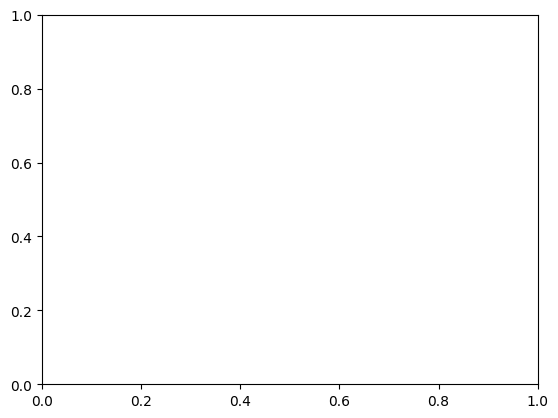

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from focal_loss import FocalLoss

logits = torch.sigmoid(torch.randn(32, 2))
target = torch.randint(0, 1, size=(32, 1))
gammas = (0, 0.5, 1, 2, 5)

plt.figure()
for gamma in gammas:
    criterion = FocalLoss(gamma=gamma)
    loss = criterion(logits, target)
    label = rf'$\gamma$={gamma}'
    if gamma == 0:
        label += ' (cross-entropy)'
    plt.plot(ps, loss, label=label)
plt.legend(loc='best', frameon=True, shadow=True)
plt.xlim(0, 1)
plt.ylim(0, 4)
plt.xlabel(r'Probability of positive class $\hat{p}$')
plt.ylabel('Loss')
plt.title(r'Plot of focal loss $L(1, \hat{p})$ for different $\gamma$', fontsize=14)
plt.show()

In [62]:
from torchmetrics.functional import concordance_corrcoef
class CCCLoss(torch.nn.Module):
    def __init__(self):
        super(CCCLoss, self).__init__()

    def forward(self, preds, target):
        ccc = concordance_corrcoef(preds, target)
        return 1 - ccc
    
criterion = CCCLoss()
preds = torch.tensor([0.1, 0.3, 0.22, 1.7, 1.0])
target = torch.tensor([0, 0, 0, 1, 1.0])
criterion(preds, target)

tensor([0.1717])

In [67]:
x = torch.tensor([
    [1, 2, 3, 3],
    [3, 4, 5, 6]
])
print(x.shape)
x[:, -1]

torch.Size([2, 4])


tensor([3, 6])

In [26]:
class ConcordanceCorCoeff(nn.Module):

    def __init__(self):
        super(ConcordanceCorCoeff, self).__init__()
        self.mean = torch.mean
        self.var = torch.var
        self.sum = torch.sum
        self.sqrt = torch.sqrt
        self.std = torch.std

    def forward(self, prediction, ground_truth):
        mean_gt = self.mean(ground_truth, 0)
        mean_pred = self.mean(prediction, 0)
        var_gt = self.var(ground_truth, 0)
        var_pred = self.var(prediction, 0)
        v_pred = prediction - mean_pred
        v_gt = ground_truth - mean_gt
        cor = self.sum(v_pred * v_gt) / (self.sqrt(self.sum(v_pred ** 2)) * self.sqrt(self.sum(v_gt ** 2)))
        sd_gt = self.std(ground_truth)
        sd_pred = self.std(prediction)
        numerator = 2 * cor * sd_gt * sd_pred
        denominator = var_gt + var_pred + (mean_gt-mean_pred)**2
        ccc = numerator/denominator
        return 1-ccc
    

ccc_loss = ConcordanceCorCoeff()
preds = torch.tensor([1, 0, 0, 0.0])
target = torch.tensor([1, 1, 0, 0.0]) 
loss = ccc_loss(preds, target) # Both pred and target must be float in nature
print(loss)

tensor(0.4839)


In [2]:
pl.seed_everything(100)

Seed set to 100


100

In [3]:
kaggle_key_path = r"C:\Users\Asus\Downloads\kaggle.json"
dataset_path = r"E:\Desktop\StutterDetModel\data"

with open(kaggle_key_path, "r") as f:
    data = json.load(f)
os.environ["KAGGLE_USERNAME"] = data["username"]
os.environ["KAGGLE_KEY"] = data["key"]
del data

if not os.path.exists(os.path.join(dataset_path, r"clips\stuttering-clips\clips")):
    print("Data is downloaded from kaggle")
    import kaggle
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files(
        "bschuss02/sep28k",
        path=dataset_path,
        unzip=True
    )
    print("Data was downloaded!")

    os.remove(os.path.join(dataset_path, "SEP-28k_episodes.csv"))
    os.remove(os.path.join(dataset_path, "SEP-28k_labels.csv"))
# os.remove(os.path.join(dataset_path, "sep28k.zip"))

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("The device is", device)

The device is cuda


In [5]:
SAMPLE_RATE = 16000
N_OUTPUT_CLASS = 2
BATCH_SIZE = 128

In [6]:

class Sep28kDataset(Dataset):
    
    def __init__(
            self, 
            data_dir=r"E:\Desktop\StutterDetModel\data",
            data_split_column="SEP28k-E", 
            stage="train", 
            label_columns=['Stutter'], 
            sample_rate=SAMPLE_RATE
    ):
        self.audio_path = os.path.join(data_dir, r"clips\stuttering-clips\clips")
        self.df_path = os.path.join(data_dir, "SEP28K.csv")
        self.label_columns = label_columns
        self.sample_rate = sample_rate
        self.num_samples = self.sample_rate * 3
        _df = pd.read_csv(self.df_path)
        _df = _df[_df[data_split_column] == stage]
        self.df = _df.reset_index(drop=True)


    def __getitem__(self, idx):
        file_path = os.path.join(self.audio_path, str(self.df.loc[idx, "FileName"]))
        labels = torch.tensor(self.df.loc[idx, self.label_columns].to_numpy().astype(np.float32))

        try:
            signal, sr = torchaudio.load(file_path, format="wav")
        except RuntimeError:
            print("RuntimeError:", file_path, idx)
            signal = torch.zeros((1, self.num_samples))
            sr = self.sample_rate
            labels = torch.zeros([len(self.label_columns)])

        labels = labels.long()
        signal = signal
        
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_channels_if_necessary(signal)
        signal = self._trim_excess_if_necessary(signal)
        signal = self._pad_if_necessary(signal)
        signal = signal.squeeze()
        
        return signal, labels


    def __len__(self):
        return len(self.df)


    def _resample_if_necessary(self, signal, sr):
        if sr != self.sample_rate:
            resampler = transforms.Resample(sr, self.sample_rate)
            signal = resampler(signal)
        return signal


    def _mix_channels_if_necessary(self, signal):
        if signal.shape[0] != 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal


    def _trim_excess_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal


    def _pad_if_necessary(self, signal):
        if signal.shape[1] < self.num_samples:
            pad_len = self.num_samples - signal.shape[1]
            signal = torch.nn.functional.pad(signal, (0, pad_len))
        return signal
    

In [7]:
ds = Sep28kDataset(dataset_path)

In [8]:
ds[3]

(tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0]))

In [9]:
len(ds)

14788

In [11]:
class Sep28kDataModule(pl.LightningDataModule):
    
    def __init__(
            self, 
            data_dir=r"E:\Desktop\StutterDetModel\data",
            num_workers=0, 
            pin_memory=False,
            batch_size=BATCH_SIZE, 
            train_split=0.8, 
            data_split_column=['SEP28k-E'], 
            label_columns=['Stutter'], 
            sample_rate=SAMPLE_RATE, 
            *args, 
            **kwargs
    ):
        super(Sep28kDataModule, self).__init__(*args, **kwargs)
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.data_split_column = data_split_column
        self.label_columns = label_columns
        self.sample_rate = sample_rate
        self.train_split = train_split

    def prepare_data(self):
        print("Data is already available")

    def setup(self, stage : str):
        if stage == "fit":
            self.train = Sep28kDataset(
                stage="train",
                sample_rate=self.sample_rate
            )
            self.val = Sep28kDataset(
                stage="dev",
                sample_rate=self.sample_rate
            )
        if stage == "test":
            self.test = Sep28kDataset(
                data_split_column=self.data_split_column,
                stage="test",
                label_columns=self.label_columns,
                sample_rate=self.sample_rate
            )
        
        if stage == "predict":
            self.predict = Sep28kDataset(
                data_split_column=self.data_split_column,
                stage="test",
                label_columns=self.label_columns,
                sample_rate=self.sample_rate
            )
    
    def train_dataloader(self):
        return DataLoader(
            dataset=self.train,
            batch_size=self.batch_size,
            shuffle=True,
        )
    
    def val_dataloader(self):
        return DataLoader(
            dataset=self.val,
            batch_size=self.batch_size,
            shuffle=False,
        )

    def test_dataloader(self):
        return DataLoader(
            dataset=self.test,
            batch_size=self.batch_size,
            shuffle=False,
        )
    
    def predict_dataloader(self):
        return DataLoader(
            dataset=self.predict,
            batch_size=self.batch_size,
            shuffle=False,
        )

In [12]:
dm = Sep28kDataModule()
dm.prepare_data()
dm.setup("fit")
for x, y in dm.train_dataloader():
    print(x.shape, x.max(), x.min())
    break

Data is already available
torch.Size([128, 48000]) tensor(1.0000) tensor(-1.)


In [38]:
wav2vec2_bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
wav2vec2_model = wav2vec2_bundle.get_model()
print(wav2vec2_model)

Wav2Vec2Model(
  (feature_extractor): FeatureExtractor(
    (conv_layers): ModuleList(
      (0): ConvLayerBlock(
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      )
      (1-4): 4 x ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (5-6): 2 x ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      )
    )
  )
  (encoder): Encoder(
    (feature_projection): FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (pos_conv_embed): ConvolutionalPositionalEmbedding(
        (conv): ParametrizedConv1d(
          768, 768, kernel_size=(128,), stride=(1,), padding=(64,), groups=16
          (parametriza

In [39]:
for param in wav2vec2_model.parameters():
    param.requires_grad = False

In [40]:
wav2vec2_model.aux = nn.Sequential(
    nn.Linear(
        in_features=768,
        out_features=128
    ),
    nn.ReLU(),
    nn.Linear(
        in_features=128,
        out_features=1
    )
)

In [41]:
class StutterModel(pl.LightningModule):
    def __init__(
            self,
            dropout_rate=0,
            learning_rate=1e-4
    ):
        super(StutterModel, self).__init__()
        self.model = wav2vec2_model
        self.criterion = nn.BCEWithLogitsLoss()
        self.learning_rate = learning_rate

    def forward(self, input_data):
        out = self.model(input_data)
        return out
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        loss = self.criterion(pred, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        loss = self.criterion(pred, y)
        self.log("val_loss", loss, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        loss = self.criterion(pred, y)
        self.log("test_loss", loss, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adagrad(
            self.parameters(),
            lr=self.learning_rate
        )


In [42]:
model = StutterModel(dropout_rate=0)
data = Sep28kDataModule(sample_rate=wav2vec2_bundle.sample_rate)

In [43]:
trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=100,
    overfit_batches=0.1
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [44]:
trainer.fit(model=model, datamodule=data)

Data is already available


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | Wav2Vec2Model     | 94.5 M
1 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
98.6 K    Trainable params
94.4 M    Non-trainable params
94.5 M    Total params
377.878   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Asus\miniconda3\envs\majorproject\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

AttributeError: 'tuple' object has no attribute 'size'